# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')



labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [2]:
print('Размер выборки:', datagen_flow.labels.shape[0])

Размер выборки: 7591


In [3]:
_range = datagen_flow.labels.min(), datagen_flow.labels.max()

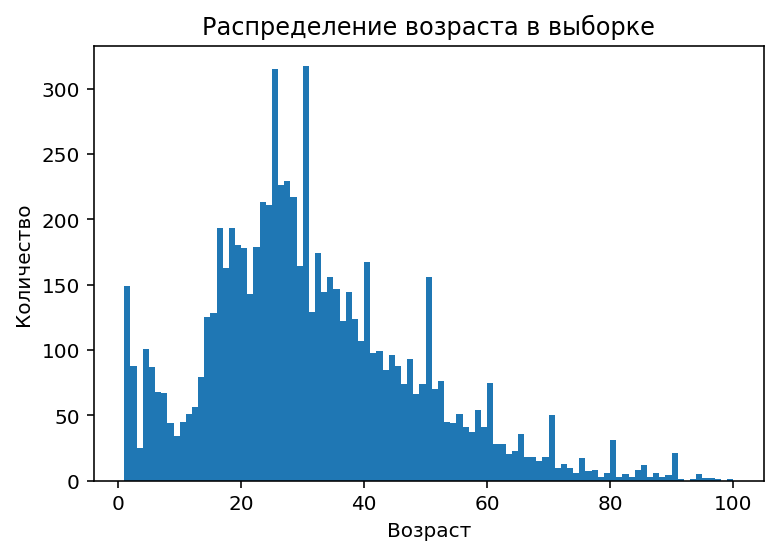

In [4]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(datagen_flow.labels, 
        range=_range,
        bins=_range[1] - _range[0]
)
ax.set(
    title='Распределение возраста в выборке',
    ylabel='Количество',
    xlabel='Возраст'
);

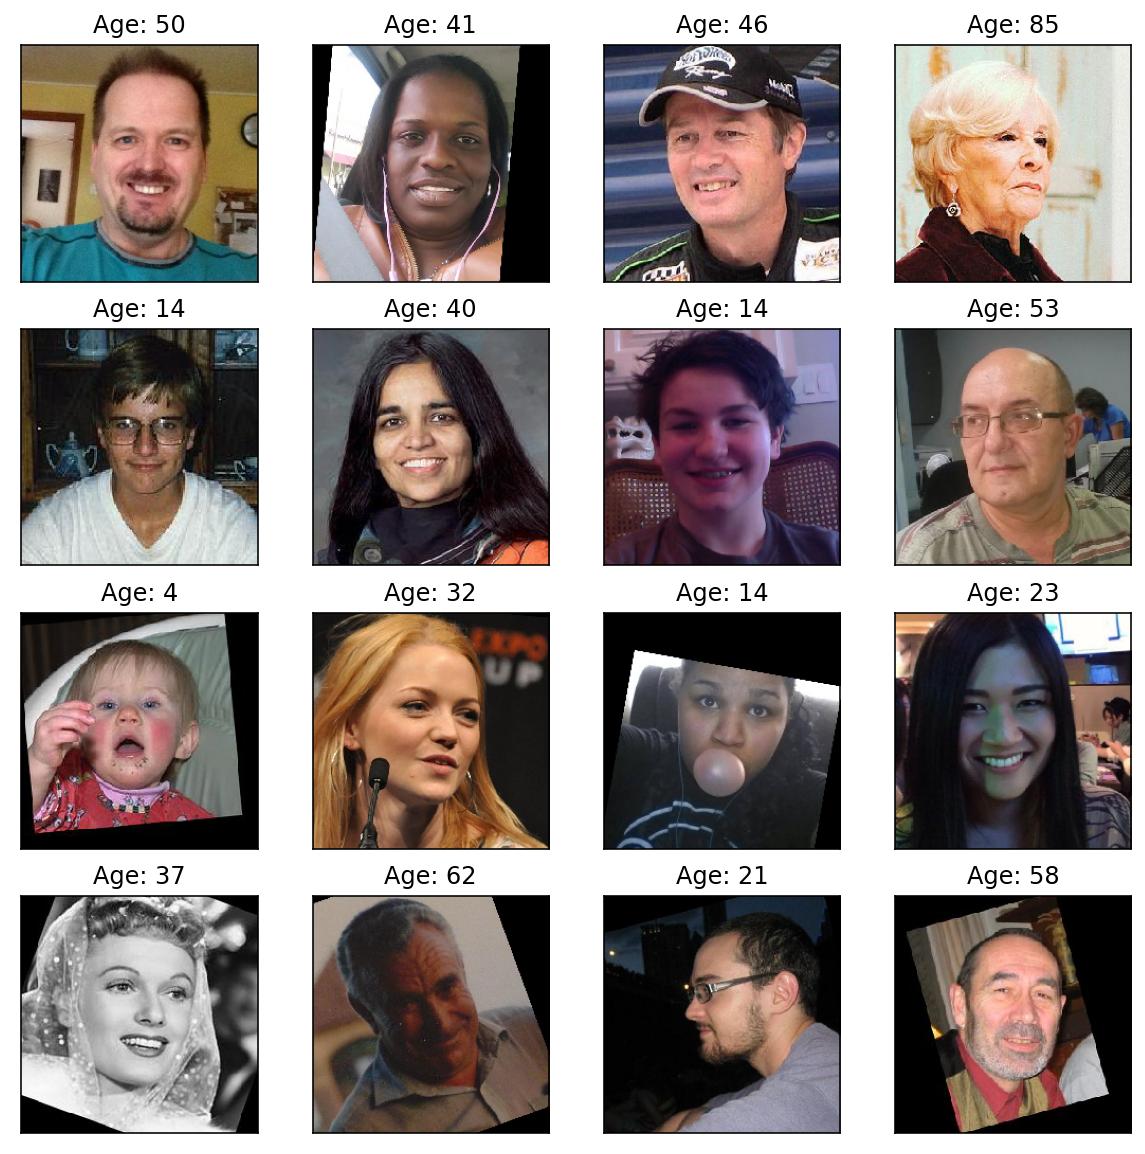

In [5]:
features, target = next(datagen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'Age: {target[i]}')
    plt.yticks([])
    plt.xticks([])

### Вывод по EDA 
Получается мы имеем первично обработанный датасет (написано в [документации](https://chalearnlap.cvc.uab.cat/dataset/26/description/)), то есть уже выделены лица и некоторые изображения развернуты, попадаются черно-белые фотографии. Данные содержат фотографии людей в диапазоне от 1 до 100 лет, преимущественно от 18 до 30 лет. Всего нам дана выборка из 7591 снимка, что не очень много и для его расширения при построении модели будет проведена дополнительная аугментация. Пока сделаем отображение снимков по горизонтали и если не достигнем нужного качества, то расширим аугментацию

## Обучение модели

Чтобы пройти порог хватило переобучить два последних слоя модели `ResNet50` без каких-либо надстроек

```python

import numpy as np
import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

def load(path, subset):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

    datagen_flow = datagen.flow_from_dataframe(
          dataframe=labels,
          directory=path + 'final_files/',
          x_col='file_name',
          y_col='real_age',
          target_size=(224, 224),
          batch_size=32,
          class_mode='raw',
          subset=subset, 
          horizontal_flip=True,
          seed=12345
    ) 
    return datagen_flow

def load_train(path):
    return load(path, subset='training')

def load_test(path):
    return load(path, subset='validation')


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(keras.layers.Dense(units=1, activation='relu'))

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

Логи обучения 

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 70s - loss: 240.1076 - mae: 11.0744 - val_loss: 884.7085 - val_mae: 24.8926
Epoch 2/10
178/178 - 37s - loss: 62.4308 - mae: 6.0001 - val_loss: 677.4942 - val_mae: 20.7427
Epoch 3/10
178/178 - 37s - loss: 30.2759 - mae: 4.2637 - val_loss: 299.5535 - val_mae: 12.7290
Epoch 4/10
178/178 - 37s - loss: 18.9980 - mae: 3.3851 - val_loss: 135.0955 - val_mae: 8.5813
Epoch 5/10
178/178 - 37s - loss: 15.3170 - mae: 3.0024 - val_loss: 77.6533 - val_mae: 6.7483
Epoch 6/10
178/178 - 37s - loss: 11.9171 - mae: 2.6779 - val_loss: 70.7297 - val_mae: 6.3188
Epoch 7/10
178/178 - 37s - loss: 9.5456 - mae: 2.3510 - val_loss: 85.5324 - val_mae: 7.3389
Epoch 8/10
178/178 - 37s - loss: 8.8297 - mae: 2.2512 - val_loss: 88.8977 - val_mae: 7.0117
Epoch 9/10
178/178 - 37s - loss: 8.4887 - mae: 2.2276 - val_loss: 72.1814 - val_mae: 6.5599
Epoch 10/10
178/178 - 37s - loss: 8.0887 - mae: 2.1595 - val_loss: 75.4583 - val_mae: 6.4576
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 75.4583 - mae: 6.4576
Test MAE: 6.4576

```

## Анализ обученной модели

Для определения возраста человека по фотографии была использована предобученная на `imagenet` данных модель `ResNet50`, которая была дообучена на предоставленном датасете с фотографиями людей в возрасте от одного года до 100 лет. Модель сумела достичь результата в `6.5` лет по метрике MAE, то есть способна давать предсказания в $\pm 7$ лет, что по сути не очень здорово. Однако и общая ситуация в предсказании возраста человека по фотографии на 2017 год обстояла не очень хорошо. Так в [статье](http://people.ee.ethz.ch/~timofter/publications/Agustsson-FG-2017.pdf) 2017 года достигнутая точность составила около 5.3 лет по метрике МАЕ. Модель `ResNet50` была создана чуть позже и показала результат чуть хуже без больших надстроек.